In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 2
commitnumber = d62b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

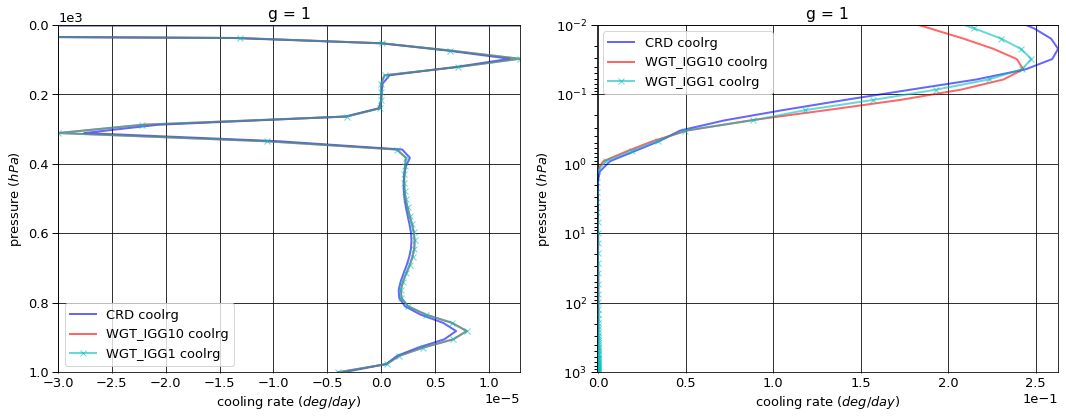

# Figure: cooling rate g-group 2

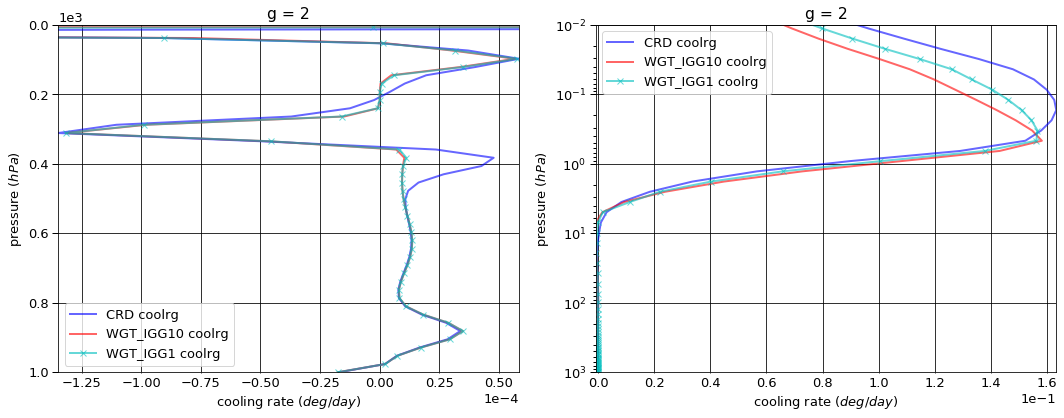

# Figure: cooling rate g-group 3

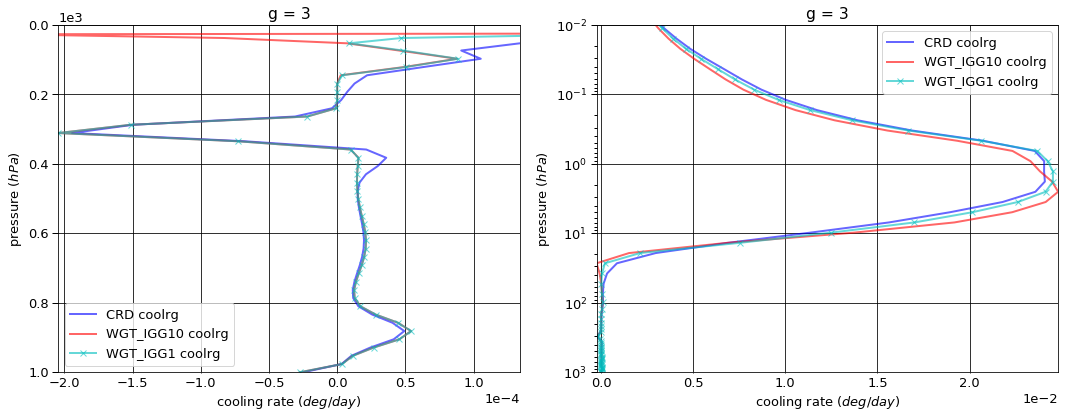

# Figure: cooling rate g-group 4

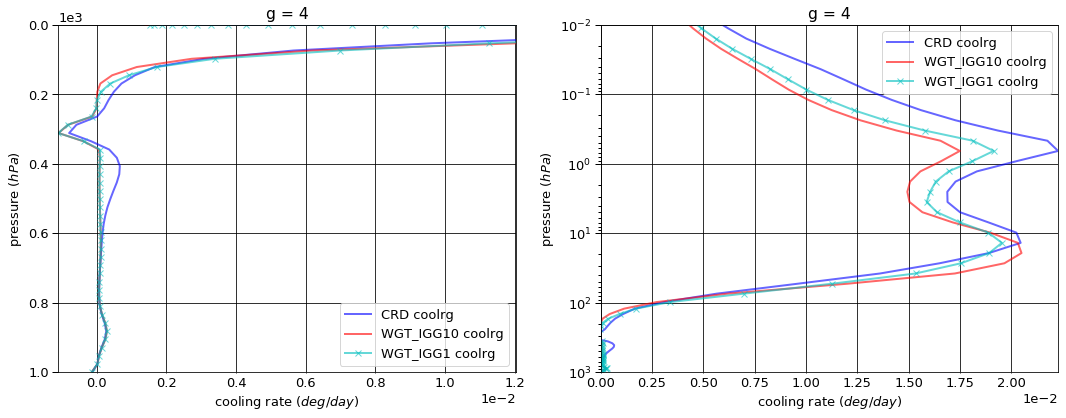

# Figure: cooling rate g-group 5

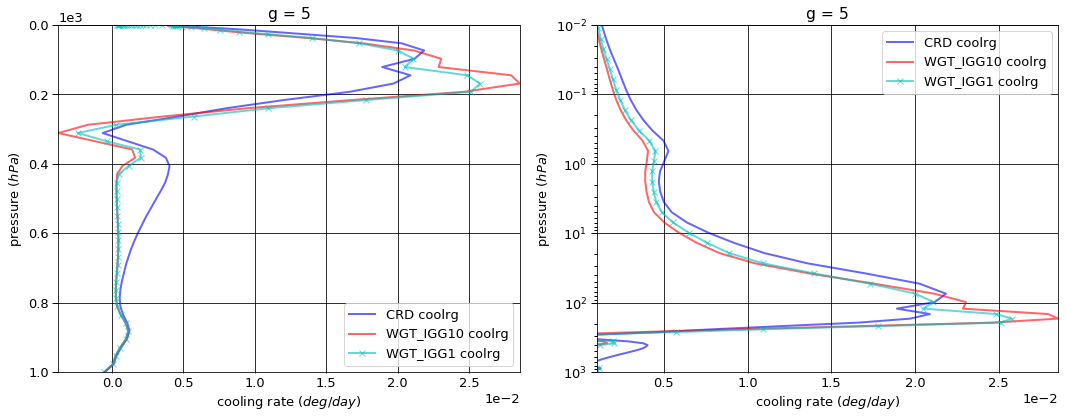

# Figure: cooling rate g-group 6

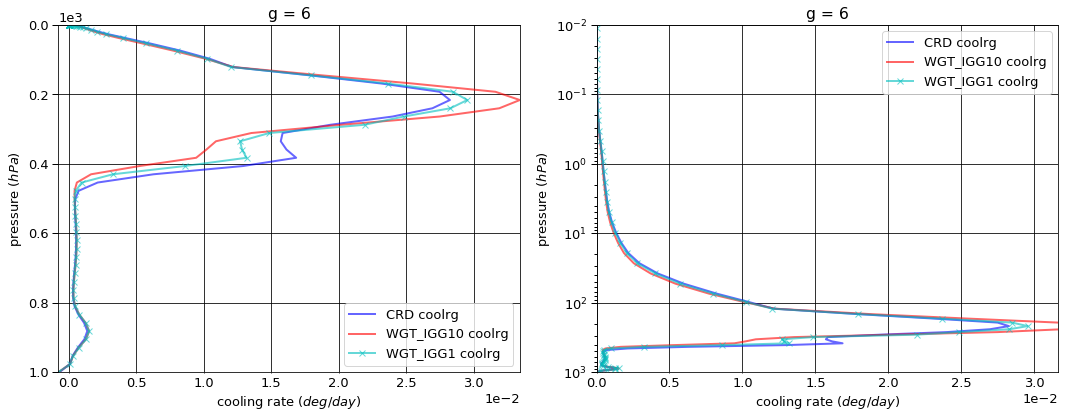

# Figure: cooling rate g-group 7

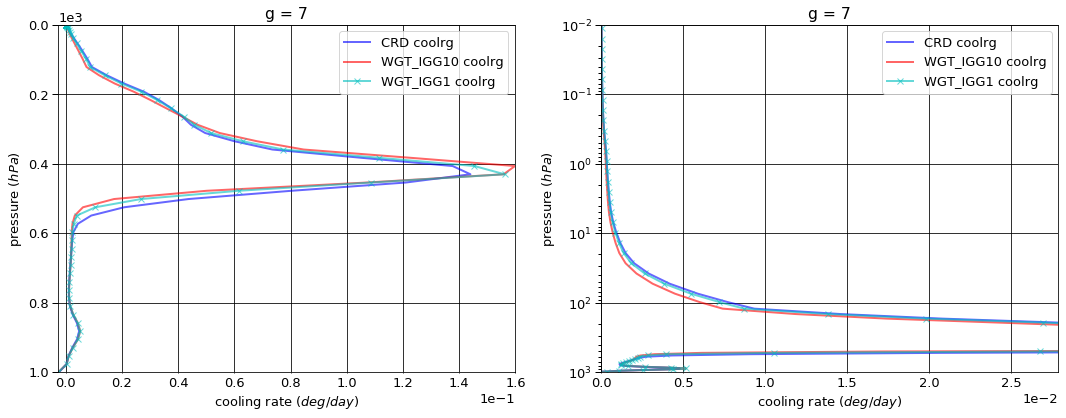

# Figure: cooling rate g-group 8

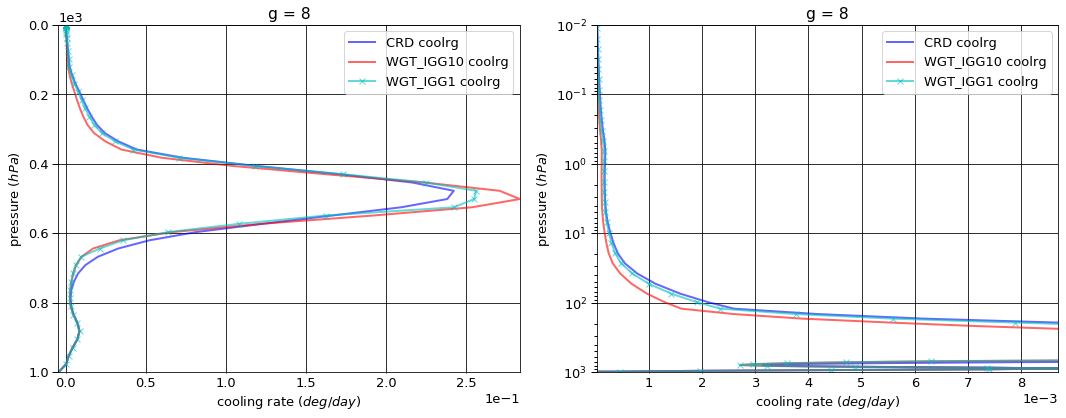

# Figure: cooling rate g-group 9

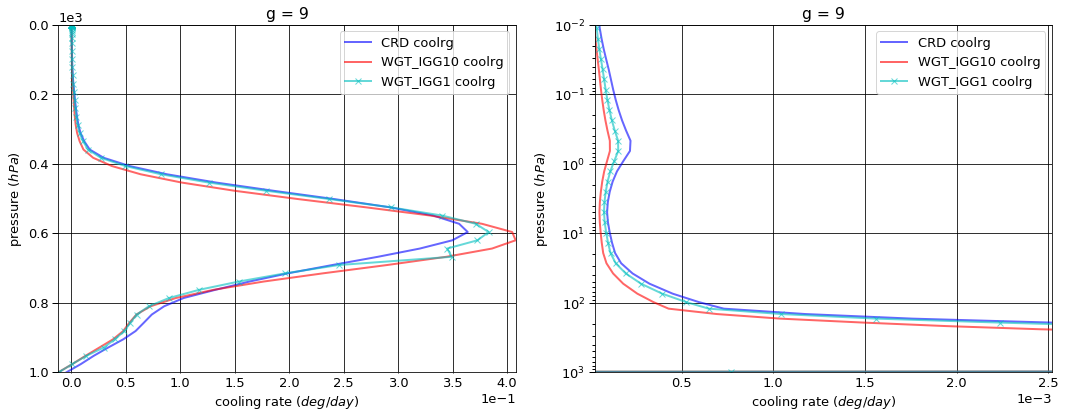

# Figure: cooling rate g-group 10

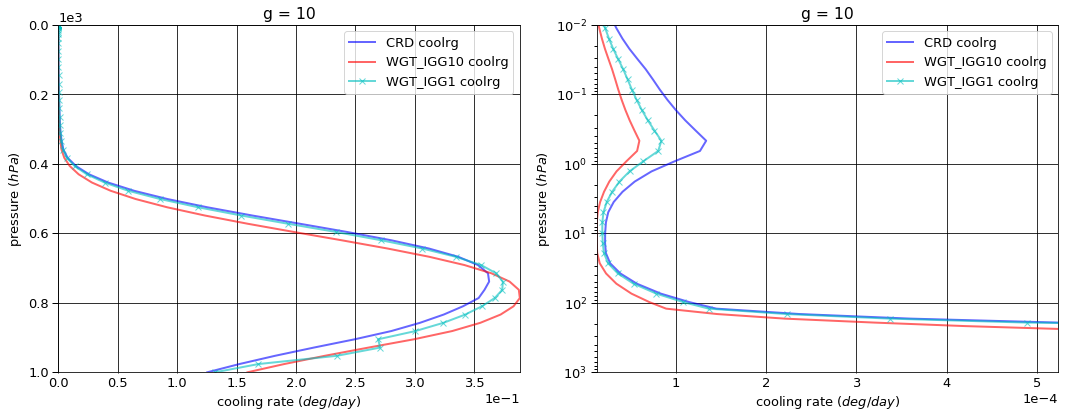

# Figure: cooling rate g-group 11

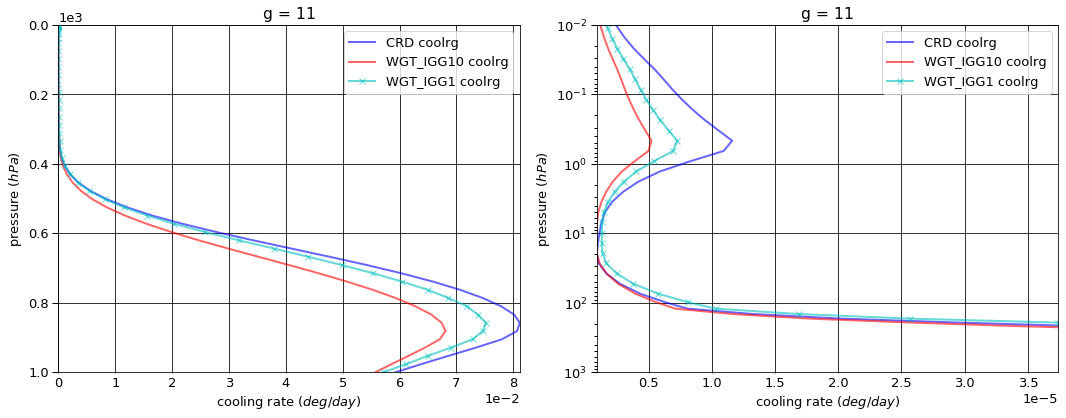

# Figure: cooling rate g-group total

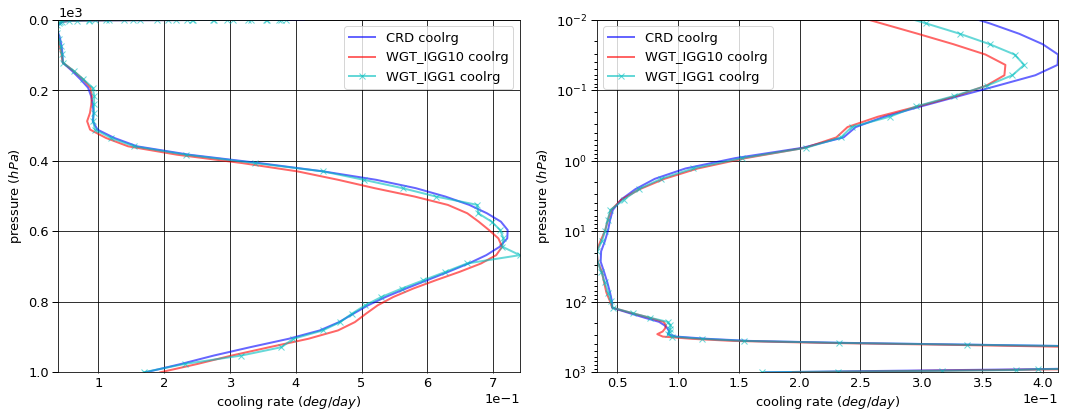

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006319   0.000000  -0.006319
   1013.0   76     -0.006844   0.006867   0.000023
2  0.0      1      -0.025595   0.000000  -0.025595
   1013.0   76     -0.030242   0.030353   0.000111
3  0.0      1      -0.031913   0.000000  -0.031913
   1013.0   76     -0.046806   0.046968   0.000162
4  0.0      1      -0.159353   0.000000  -0.159353
   1013.0   76     -0.252603   0.253504   0.000901
5  0.0      1      -0.642279   0.000000  -0.642279
   1013.0   76     -0.986034   0.989216   0.003182
6  0.0      1      -0.854218   0.000000  -0.854218
   1013.0   76     -1.309782   1.314318   0.004536
7  0.0      1      -3.173688   0.000000  -3.173688
   1013.0   76     -4.473250   4.489017   0.015767
8  0.0      1      -5.615485   0.000000  -5.615485
   1013.0   76     -7.087958   7.116509   0.028550
9  0.0      1     -12.101921   0.000000 -12.101921
   1013.0   76    -13.700012  13.753067   0.053056
10 0.0      1     -20.242747   0.000000 -20.242747
   1013.0   76    -21.118582  17.464912  -3.653671
11 0.0      1      -9.074832   0.000000  -9.074832
   1013.0   76     -9.171416   3.509942  -5.661474


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006339   0.000000  -0.006339
   1013.0   76     -0.006904   0.006930   0.000026
2  0.0      1      -0.026164   0.000000  -0.026164
   1013.0   76     -0.030310   0.030424   0.000114
3  0.0      1      -0.031209   0.000000  -0.031209
   1013.0   76     -0.047107   0.047285   0.000178
4  0.0      1      -0.151538   0.000000  -0.151538
   1013.0   76     -0.253901   0.254859   0.000959
5  0.0      1      -0.603124   0.000000  -0.603124
   1013.0   76     -0.990975   0.994718   0.003743
6  0.0      1      -0.814924   0.000000  -0.814924
   1013.0   76     -1.318058   1.323036   0.004978
7  0.0      1      -3.073019   0.000000  -3.073019
   1013.0   76     -4.496177   4.513158   0.016980
8  0.0      1      -5.582121   0.000000  -5.582121
   1013.0   76     -7.118687   7.147185   0.028498
9  0.0      1     -12.157582   0.000000 -12.157582
   1013.0   76    -13.730419  13.853510   0.123091
10 0.0      1     -20.414223   0.000000 -20.414223
   1013.0   76    -21.096789  17.632740  -3.464049
11 0.0      1      -9.035880   0.000000  -9.035880
   1013.0   76     -9.094203   2.830162  -6.264041


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006327   0.000000  -0.006327
   1013.0   76     -0.006904   0.006930   0.000026
2  0.0      1      -0.025974   0.000000  -0.025974
   1013.0   76     -0.030310   0.030424   0.000114
3  0.0      1      -0.031111   0.000000  -0.031111
   1013.0   76     -0.047107   0.047285   0.000178
4  0.0      1      -0.152107   0.000000  -0.152107
   1013.0   76     -0.253901   0.254859   0.000959
5  0.0      1      -0.603532   0.000000  -0.603532
   1013.0   76     -0.990975   0.994718   0.003743
6  0.0      1      -0.819313   0.000000  -0.819313
   1013.0   76     -1.318058   1.323036   0.004978
7  0.0      1      -3.080921   0.000000  -3.080921
   1013.0   76     -4.496177   4.513158   0.016980
8  0.0      1      -5.528352   0.000000  -5.528352
   1013.0   76     -7.118687   7.147360   0.028673
9  0.0      1     -12.048644   0.000000 -12.048644
   1013.0   76    -13.730419  13.847019   0.116600
10 0.0      1     -20.268860   0.000000 -20.268860
   1013.0   76    -21.096789  17.988466  -3.108323
11 0.0      1      -9.014101   0.000000  -9.014101
   1013.0   76     -9.094203   3.258757  -5.835445


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000020  0.000000 -0.000020
   1013.0   76    -0.000060  0.000063  0.000003
2  0.0      1     -0.000569  0.000000 -0.000569
   1013.0   76    -0.000068  0.000072  0.000004
3  0.0      1      0.000704  0.000000  0.000704
   1013.0   76    -0.000301  0.000317  0.000016
4  0.0      1      0.007815  0.000000  0.007815
   1013.0   76    -0.001297  0.001355  0.000058
5  0.0      1      0.039155  0.000000  0.039155
   1013.0   76    -0.004941  0.005502  0.000561
6  0.0      1      0.039295  0.000000  0.039295
   1013.0   76    -0.008276  0.008718  0.000442
7  0.0      1      0.100670  0.000000  0.100670
   1013.0   76    -0.022927  0.024140  0.001213
8  0.0      1      0.033364  0.000000  0.033364
   1013.0   76    -0.030729  0.030676 -0.000052
9  0.0      1     -0.055661  0.000000 -0.055661
   1013.0   76    -0.030407  0.100443  0.070035
10 0.0      1     -0.171476  0.000000 -0.171476
   1013.0   76     0.021793  0.167828  0.189621
11 0.0      1      0.038952  0.000000  0.038952
   1013.0   76     0.077214 -0.679781 -0.602567


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000008  0.000000 -0.000008
   1013.0   76    -0.000060  0.000063  0.000003
2  0.0      1     -0.000379  0.000000 -0.000379
   1013.0   76    -0.000068  0.000072  0.000004
3  0.0      1      0.000802  0.000000  0.000802
   1013.0   76    -0.000301  0.000317  0.000016
4  0.0      1      0.007246  0.000000  0.007246
   1013.0   76    -0.001297  0.001355  0.000058
5  0.0      1      0.038747  0.000000  0.038747
   1013.0   76    -0.004941  0.005502  0.000561
6  0.0      1      0.034906  0.000000  0.034906
   1013.0   76    -0.008276  0.008718  0.000442
7  0.0      1      0.092768  0.000000  0.092768
   1013.0   76    -0.022927  0.024140  0.001213
8  0.0      1      0.087132  0.000000  0.087132
   1013.0   76    -0.030729  0.030851  0.000123
9  0.0      1      0.053277  0.000000  0.053277
   1013.0   76    -0.030407  0.093952  0.063545
10 0.0      1     -0.026113  0.000000 -0.026113
   1013.0   76     0.021793  0.523554  0.545348
11 0.0      1      0.060730  0.000000  0.060730
   1013.0   76     0.077214 -0.251185 -0.173971

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      9.968190e-02
   1001.112500 75    -3.520747e-06
2  0.000312    1      2.346175e-02
   1001.112500 75    -1.708632e-05
3  0.000312    1      7.454472e-04
   1001.112500 75    -2.493391e-05
4  0.000312    1      1.726985e-03
   1001.112500 75    -1.384439e-04
5  0.000312    1      4.098157e-04
   1001.112500 75    -5.158541e-04
6  0.000312    1      2.070151e-06
   1001.112500 75    -6.987931e-04
7  0.000312    1      7.025039e-06
   1001.112500 75    -2.429747e-03
8  0.000312    1      8.472483e-06
   1001.112500 75    -4.415693e-03
9  0.000312    1      1.123814e-05
   1001.112500 75    -4.562120e-03
10 0.000312    1      5.063021e-06
   1001.112500 75     1.253700e-01
11 0.000312    1      1.678019e-07
   1001.112500 75     5.926545e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      4.710773e-02
   1001.112500 75    -4.021022e-06
2  0.000312    1      1.729423e-02
   1001.112500 75    -1.765305e-05
3  0.000312    1      7.379063e-04
   1001.112500 75    -2.743590e-05
4  0.000312    1      1.405779e-03
   1001.112500 75    -1.478767e-04
5  0.000312    1      3.325945e-04
   1001.112500 75    -5.771637e-04
6  0.000312    1      1.769830e-06
   1001.112500 75    -7.676632e-04
7  0.000312    1      5.277120e-06
   1001.112500 75    -2.618663e-03
8  0.000312    1      4.157330e-06
   1001.112500 75    -4.478559e-03
9  0.000312    1      4.949904e-06
   1001.112500 75    -1.206474e-02
10 0.000312    1      2.150852e-06
   1001.112500 75     1.592291e-01
11 0.000312    1      1.567304e-07
   1001.112500 75     5.572187e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      6.418170e-02
   1001.112500 75    -4.021022e-06
2  0.000312    1      1.925427e-02
   1001.112500 75    -1.765305e-05
3  0.000312    1      7.630409e-04
   1001.112500 75    -2.743590e-05
4  0.000312    1      1.517029e-03
   1001.112500 75    -1.478767e-04
5  0.000312    1      3.692147e-04
   1001.112500 75    -5.771637e-04
6  0.000312    1      1.960918e-06
   1001.112500 75    -7.676632e-04
7  0.000312    1      6.555772e-06
   1001.112500 75    -2.618663e-03
8  0.000312    1      6.247757e-06
   1001.112500 75    -4.505881e-03
9  0.000312    1      7.790769e-06
   1001.112500 75    -1.166300e-02
10 0.000312    1      3.507197e-06
   1001.112500 75     1.319139e-01
11 0.000312    1      2.360082e-07
   1001.112500 75     5.715132e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.257417e-02
   1001.112500 75    -5.002749e-07
2  0.000312    1     -6.167517e-03
   1001.112500 75    -5.667370e-07
3  0.000312    1     -7.540850e-06
   1001.112500 75    -2.501990e-06
4  0.000312    1     -3.212064e-04
   1001.112500 75    -9.432810e-06
5  0.000312    1     -7.722115e-05
   1001.112500 75    -6.130956e-05
6  0.000312    1     -3.003209e-07
   1001.112500 75    -6.887018e-05
7  0.000312    1     -1.747919e-06
   1001.112500 75    -1.889165e-04
8  0.000312    1     -4.315153e-06
   1001.112500 75    -6.286540e-05
9  0.000312    1     -6.288237e-06
   1001.112500 75    -7.502617e-03
10 0.000312    1     -2.912169e-06
   1001.112500 75     3.385909e-02
11 0.000312    1     -1.107151e-08
   1001.112500 75    -3.543579e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.550020e-02
   1001.112500 75    -5.002749e-07
2  0.000312    1     -4.207479e-03
   1001.112500 75    -5.667370e-07
3  0.000312    1      1.759372e-05
   1001.112500 75    -2.501990e-06
4  0.000312    1     -2.099568e-04
   1001.112500 75    -9.432810e-06
5  0.000312    1     -4.060095e-05
   1001.112500 75    -6.130956e-05
6  0.000312    1     -1.092336e-07
   1001.112500 75    -6.887018e-05
7  0.000312    1     -4.692665e-07
   1001.112500 75    -1.889163e-04
8  0.000312    1     -2.224726e-06
   1001.112500 75    -9.018800e-05
9  0.000312    1     -3.447372e-06
   1001.112500 75    -7.100878e-03
10 0.000312    1     -1.555824e-06
   1001.112500 75     6.543860e-03
11 0.000312    1      6.820630e-08
   1001.112500 75    -2.114125e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.928349,0.000000,-51.928349
1013.0,76,-58.183530,48.974672,-9.208858



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.896122,0.000000,-51.896122
1013.0,76,-58.183529,48.634006,-9.549524



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.579242,0.000000,-51.579242
1013.0,76,-58.183529,49.412011,-8.771518



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.222690e-02,0.000000,0.032227
1013.0,76,3.646000e-07,-0.340666,-0.340666



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.491076e-01,0.000000,0.349108
1013.0,76,3.646000e-07,0.437339,0.437340


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.126060
1001.112500,75,0.171829



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.066897
1001.112500,75,0.194247



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.086112
1001.112500,75,0.168736



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.059163
1001.112500,75,0.022418



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.039948
1001.112500,75,-0.003093


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
